## Import Library

In [1]:
from plotly import graph_objs as go
from plotly.subplots import make_subplots
from plotly import express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import*
from subprocess import call
import os
pd.options.plotting.backend = "plotly"
from PIL import Image
from IPython.display import Image as IPImage
import shutil
from pathlib import Path

## Functions

In [2]:
def create_folder(main_dir: str, folder: str):
    folder_path = main_dir / folder
    if not folder_path.exists():
        folder_path.mkdir()
        print(f'Folder {folder_path.name} is created')
    else:
        print(f'Folder {folder_path.name} already exists')
    
    return folder_path

def create_txt(filename):
    '''
    'r' (read-only) (default), 'w' (write - erase all contents for existing file), 'a' (append), 'r+' (read and write)
    '''
    with open(filename, "w") as file:
        file.close()
        
def create_rewrite_file(work_dir, root_file: str, new_file: str, parameter: str, steps: np.array, new_lines: str, app_path: str, change_line: str) -> None:
    #create_txt('autorun.bat')
    autorun_f =  (work_dir / 'autorun.bat').open(mode='w')  

    if change_line == 'here':
        for step in steps:
            # Create new txt file
            step_file = f'{new_file}_{step}.in'
            #create_txt(step_file)

            # Add file name at autorun file
            autorun_f.write(
                f'{app_path} < {step_file} > {new_file}_{step}.out\n'
            )

            # Rewrite txt file with changed parameter values
            with (work_dir / root_file).open(mode='r+') as f1, (work_dir / step_file).open(mode='w') as f2:
                for line1 in f1:
                    if parameter in line1:
                        new_line = new_lines[step]
                        f2.write(new_line)
                    else:
                        f2.write(line1)

                f1.close(), f2.close()
    
    elif change_line == 'next':
            for step in steps:
                # Create new txt file
                step_file = f'{new_file}_{step+1}.in'
                #create_txt(step_file)

                # Add file name at autorun file
                autorun_f.write(
                    f'{app_path} < {step_file} > {new_file}_{step}.out\n'
                )

                # Rewrite txt file with changed parameter values
                with (work_dir / root_file).open(mode='r+') as f1, (work_dir / step_file).open(mode='w') as f2:
                    flag = False
                    for line1 in f1:
                        if flag:
                            f2.write(new_lines[step])
                            flag = False
                        elif parameter in line1:
                            f2.write(line1)
                            flag = True
                        else:
                            f2.write(line1)

                    f1.close(), f2.close()

                
    autorun_f.close()
        
def find_total_energy(work_dir, new_file: str, steps: list[int]) -> np.array:
    total_energy = np.zeros(len(steps))
    for step in steps:
        with (work_dir / f'{new_file}_{step}.out').open(mode='r') as f1:
            for line in f1:
                if '!' in line and 'total energy' in line:
                    total_energy[step] = float(line.split(' ')[-2])
                    break
            f1.close()     
    return total_energy

# def find_UnitCell_volume(new_file: str, steps: list[int]) -> list:
#     unitCell_volume = []
#     for step in steps:
#         with open(f'{new_file}_{step}.out') as f1:
#             for line in f1:
#                 if 'unit-cell volume' in line:
#                     unitCell_volume.append(float(line.split(' ')[-2]))
#                     f1.close()
#                     break

#     return unitCell_volume

## MAIN DIRECTORY

> **IMPORTANT**

> Insert path to the main directory where all necessary files will be created and computed.

In [3]:
main_dir = Path('C:\\Users\\79179\\Desktop\\шк\\Skoltech_PhD\\Computational_Methods_for_Atomistic_Simulations\\Labs\\Lab_test')
if main_dir.exists():
    print('Main Directory:')
    print(main_dir)
else:
    print('Directory does not exists')

Main Directory:
C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test


## DOWNLOAD and Prepare necessary input files

You need to prepare **ATOMIC POSITIONS** and **CELL PARAMETERS** for input files. You can take the crystal structure of your own material.

If you do not have your own material, you can choose one of them here: <br>
https://next-gen.materialsproject.org/materials <br>
Materials Project website contains information about most of the existing structures. You need to download **CIF** file.

You need to download pseudopotentials for each atom in your structure. **PSEUDOPOTENTIALS** for atoms you can find here: <br>
PSEUDO_DOJO: http://www.pseudo-dojo.org/index.html <br>
QUANTUM ESPRESSO: https://pseudopotentials.quantum-espresso.org/legacy_tables

> **IMPORTANT** Please, place pseudopotentials in the main directory mentioned above.

Also, you can read **DOCUMENTATION for .INPUT** files: <br>
https://www.quantum-espresso.org/documentation/input-data-description/

## Cut-off Energy Optimization

### Create working directory

In [17]:
opt_energy_path = create_folder(main_dir=main_dir, folder='1.OPT.energy')

Folder 1.OPT.energy already exists


### Create input file according to the documentation

In [12]:
new_file = 'ab_f.in'

In [13]:
%%writefile {opt_energy_path / new_file}
&CONTROL
  calculation = 'scf'
  etot_conv_thr =   6.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = '.'
  pseudo_dir = '../'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc =   45
  ibrav = 0
  nat = 6
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   1.2000000000d-09
  electron_maxstep = 80
  mixing_beta =   0.4
  diagonalization = 'cg'
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
6 6 1 0 0 0

CELL_PARAMETERS angstrom
      2.5668995380       0.0000000000       0.0000000000
      1.2834500650       2.2230000380       0.0000000000
      0.0016438986       0.0009644628      19.9764861151

Overwriting C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\1.OPT.energy\ab_f.in


### Create files with different cut-off energy values

In [ ]:
parameter = 'ecutwfc'
ecut_vals = np.arange(10, 61, 5)
ecut_lines = [f'{parameter} = {i}\n' for i in np.arange(10, 61, 5)]

create_rewrite_file(
    work_dir=opt_energy_path,
    root_file='ab_f.in', 
    new_file=new_file,
    parameter=parameter,
    steps=np.arange(len(ecut_lines)),
    new_lines=ecut_lines,
    app_path='C:/Users/79179/Desktop/qe/pw.exe',
    change_line='here',
)

> **RUN CALCULATIONS**

In [8]:
call(["autorun1.bat"])

0

### Find total energy for each calculation and Build figure

In [ ]:
total_energy = find_total_energy(
    work_dir=opt_energy_path,
    new_file=new_file,
    steps=np.arange(len(ecut_lines)),
)

### Figure: Total Energy vs Ecut

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=ecut_vals,
               y=total_energy,
               line_color=color_dict[0],
               line_width=5,
               showlegend=False,
               name=''
               ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                  font_color='black',
                #title = f"date: 24.02.24 <br> Mixture: Methyl solution",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 1000,
                height = 600,   
                # X-axis
                xaxis_title = "Ecut, Ry",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                # Y-axis-right
                yaxis_title = "Total Energy, Ry",
                yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside' 
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file=opt_energy_path / "Ecut_vs_TotEnerg.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
fig.show()

## K-points Grid Optimization

### Create working directory

In [18]:
opt_kpoints_path = create_folder(main_dir=main_dir, folder='1.OPT.kpoints')

Folder 1.OPT.kpoints already exists


### Create input file according to documentation

> Choose optimal cut-off `ecutwfc` energy from previous step and insert it to the new input file

In [19]:
%%writefile {opt_kpoints_path / new_file}
&CONTROL
  calculation = 'scf'
  etot_conv_thr =   6.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = '.'
  pseudo_dir = '../'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc =   45
  ibrav = 0
  nat = 6
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   1.2000000000d-09
  electron_maxstep = 80
  mixing_beta =   0.4
  diagonalization = 'cg'
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
6 6 1 0 0 0

CELL_PARAMETERS angstrom
      2.5668995380       0.0000000000       0.0000000000
      1.2834500650       2.2230000380       0.0000000000
      0.0016438986       0.0009644628      19.9764861151

Writing C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\1.OPT.kpoints\ab_f.in


### Create input files with different k-points grid

In [20]:
kpts_values = np.arange(6, 13, 1)
kpts_lines = [f'   {i} {i} 1 0 0 0' for i in kpts_values]
create_rewrite_file(
    work_dir=opt_kpoints_path,
    root_file='ab_f.in', 
    new_file=new_file, 
    parameter='K_POINTS',
    steps=np.arange(len(kpts_lines)),
    new_lines=kpts_lines,
    app_path='C:/Users/79179/Desktop/qe/pw.exe',
    change_line='next',
)

> **RUN CALCULATIONS**

In [31]:
call(["autorun.bat"])

0

### Find total energy for each calculation and Build Figure

In [ ]:
kpoints_total_energy = find_total_energy(
    work_dir=opt_kpoints_path,
    new_file=new_file,
    steps=np.arange(len(kpts_lines)),
)

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=kpts_values,
               y=kpoints_total_energy,
               line_color=color_dict[0],
               line_width=5,
               showlegend=False,
               name=''
               ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                  font_color='black',
                #title = f"date: 24.02.24 <br> Mixture: Methyl solution",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 1000,
                height = 600,   
                # X-axis
                xaxis_title = "K points",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                # Y-axis-right
                yaxis_title = "Total Energy, Ry",
                yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside' 
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file=opt_kpoints_path / "TotEnerg_vs_Kpoints.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
fig.show()

## Relaxation

### Create working directory

In [6]:
relax_path = create_folder(main_dir=main_dir, folder='2.OPT.Relaxation')

Folder 2.OPT.Relaxation already exists


### Create input file for structure relaxation

> Choose optimal cut-off `ecutwfc` energy and `K_POINTS` grid from previous steps and insert it to the new input file

In [35]:
%%writefile {relax_path / 'ab_f_relax.in'}
&CONTROL
  calculation = 'vc-relax'
  etot_conv_thr =   1.0d-05
  forc_conv_thr =   1.0d-04
  outdir = '.'
  pseudo_dir = '../'
  disk_io = 'none'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
  nstep=1000
/
&SYSTEM
  degauss =   0.05
  ecutwfc = 45
  ibrav = 0
  nat = 6
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   1.0d-8
  electron_maxstep = 100
  mixing_beta =   0.4
  diagonalization = 'cg'
/
&IONS
  ion_dynamics = 'bfgs'
  pot_extrapolation = "first_order"
/
&CELL
  cell_dynamics = 'bfgs'
  cell_dofree = '2Dxy'
  press = 0
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
12 12 1 0 0 0

CELL_PARAMETERS angstrom
      2.5668995380       0.0000000000       0.0000000000
      1.2834500650       2.2230000380       0.0000000000
      0.0016438986       0.0009644628      19.9764861151

Overwriting C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\2.OPT.Relaxation\ab_f_relax.in


> **RUN CALCULATIONS**: pw.x < ab_f_relax.in > ab_f_relax.out

### Self-consistent field (SCF) Calculation

> Please, open output from relaxation step and in the end of the file below "Final enthalpy" you find **CELL_PARAMETERS** <br>

> Copy CELL_PARAMETERS to SCF input file

In [ ]:
%%writefile {relax_path / 'ab_f_scf.in'}
&CONTROL
  calculation = 'scf'
  etot_conv_thr =   1.0d-05
  forc_conv_thr =   1.0d-04
  outdir = '.'
  pseudo_dir = '../'
  verbosity = 'high'
  prefix = 'ab_f'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc = 45
  ibrav = 0
  nat = 6
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
/
&IONS
ion_dynamics = 'bfgs'
/
&CELL
cell_dofree = 'all'
cell_dynamics = 'bfgs'
press = 0.0
press_conv_thr = 0.5
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
12 12 1 0 0 0

CELL_PARAMETERS angstrom
   2.546011282  -0.000000525   0.000000000
   1.273005480   2.204910623   0.000000000
   0.001630521   0.000956614  19.976486115

Overwriting C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\2.OPT.Relaxation\ab_f_scf.in


> **RUN CALCULATIONS**: pw.x  <  ab_f_scf.in  >  ab_f_scf.out

## DOS Calculation

### Create a working directory

In [4]:
dos_path = create_folder(main_dir=main_dir, folder='3.eDOS')

Folder 3.eDOS already exists


### SCF Input File

> **COPY SCF OUTPUT** calculations from previous step

> You can create a new SCF INPUT file and recalculate it

In [ ]:
shutil.copy(relax_path / "ab_f_scf.out", dos_path / "ab_f_scf.out")
shutil.copy(relax_path / "pwscf.save", dos_path / "pwscf.save")
shutil.copy(relax_path / "ab_f.xml", dos_path / "ab_f.xml")

WindowsPath('C:/Users/79179/Desktop/шк/Skoltech_PhD/Computational_Methods_for_Atomistic_Simulations/Labs/Lab_test/3.eDOS/ab_f.xml')

### NSCF Input File

> **DO NOT FORGET**
- Increase K-points grid twice or more for accurate calculations
- Calculate `nbnd` += atom * number of valence electrons. <br>
Example: nbnd = 4(number of Carbon atoms) * C(valence electrons=4) + 2(number of Fluorine atoms) * F(valence electrons=7) = 30


In [33]:
%%writefile {dos_path / 'ab_f_nscf.in'}
&CONTROL
  calculation = 'nscf'
  etot_conv_thr =   6.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = '.'
  pseudo_dir = '../'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc = 45
  ibrav = 0
  nat = 6
  nbnd = 30
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
24 24 2 0 0 0

CELL_PARAMETERS angstrom
      2.5668995380       0.0000000000       0.0000000000
      1.2834500650       2.2230000380       0.0000000000
      0.0016438986       0.0009644628      19.9764861151

Overwriting C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\3.eDOS\ab_f_nscf.in


### DOS Input File

In [ ]:
%%writefile {dos_path / 'dos.in'}
&dos
DeltaE = 0.1
/


Overwriting C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\3.eDOS\dos.in


**DO NOT FORGET** about space after **/** in dos.input file, because sometimes the QE program cannot read this file

> **RUN CALCULATIONS** <br>
pw.x < ab_f_scf.in > ab_f_scf.out <br>
pw.x < ab_f_nscf.in > ab_f_nscf.out <br>
dos.x < dos.in > dos.out

### Calculate DOS values and Build Figure

In [36]:
def dos_vals(work_dir: str, fn: str):
    with (work_dir / fn).open(mode='r+') as f:
        lines = f.readlines()
        # Fermi Energy
        FermiE = float(lines[0].split(' ')[-2])
        # Calculation DOS points
        Energy = np.zeros(len(lines)-1)
        DOS_E = np.zeros_like(Energy)
        for i, line in enumerate(lines[1:]):
            Energy[i] = float(list(filter(None, line.split(' ')))[0])
            DOS_E[i] = float(list(filter(None, line.split(' ')))[1])
        f.close()
    return FermiE, Energy, DOS_E

def band_gap(energy: np.array, dos: np.array, e_trs: float) -> int:
    assert len(energy) == len(dos)
    for i, E in enumerate(dos[energy>0]):
        if E > e_trs:
            break

    for j, E in enumerate(dos[energy<0][::-1]):
        if E > e_trs:
            break
    return energy[energy>0][i] + np.abs(energy[energy<0][::-1][j])

In [37]:
FermiE, Energy, DOS_E = dos_vals(work_dir=dos_path, fn='pwscf.dos')
shifted_energy = Energy - FermiE

In [38]:
print(f'Fermi Energy = {FermiE}')
print(f'Band Gap = {band_gap(energy=shifted_energy, dos=DOS_E, e_trs=0.1)}')

Fermi Energy = -0.06
Band Gap = 4.0


In [40]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=shifted_energy,
            y=DOS_E,
            line_color=color_dict[0],
            line_width=5,
            showlegend=False,
            name=''
            ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                font_color='black',
                title = f"Electronic Density of States",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 2250,
                height = 1500,   
                # X-axis
                xaxis_title = "Energy, eV",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                xaxis_range = [-30, 20],
                # Y-axis-right
                yaxis_title = "DOS (E)",
                #yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                yaxis_range = [0, max(DOS_E)],
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside',
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))
fig.add_vline(x=0)
fig.layout.font.family = 'sans-serif'
fig.write_image(file=dos_path / "DOS.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
#fig.show()

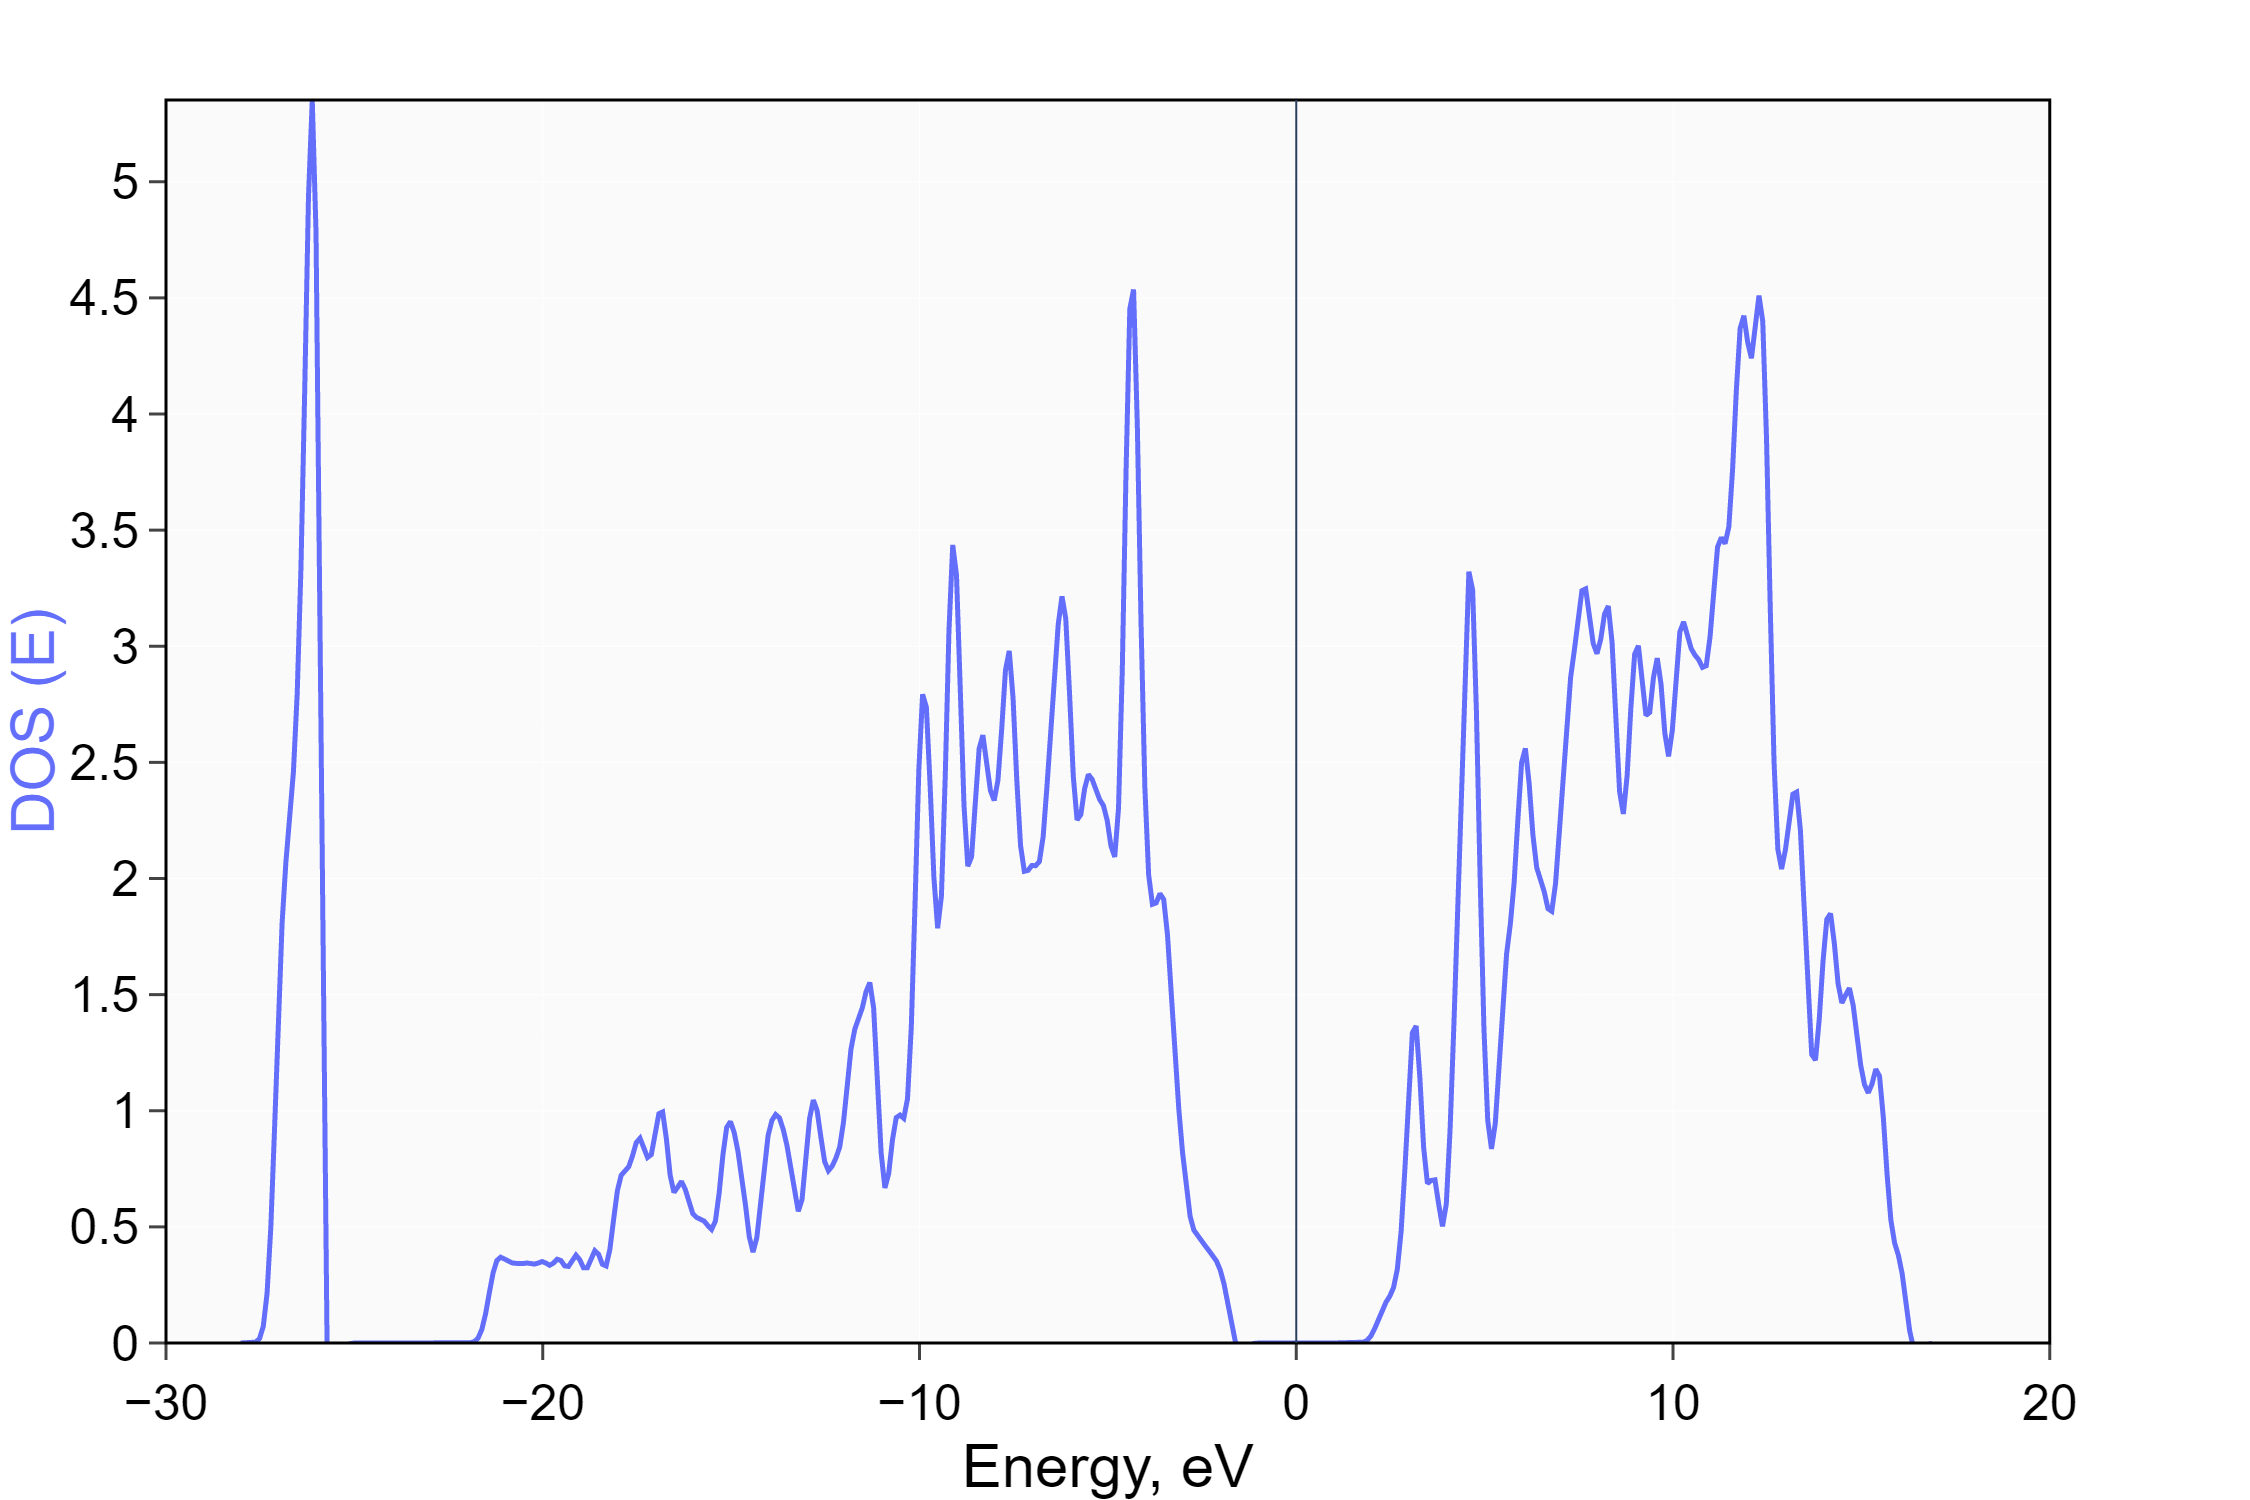

In [42]:
IPImage(open('DOS.png','rb').read())

### Rotated Figure for merging with Bands structure

In [44]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=DOS_E,
            y=shifted_energy,
            line_color=color_dict[0],
            line_width=5,
            showlegend=False,
            name=''
            ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                font_color='black',
                #title = f"date: 24.02.24 <br> Mixture: Methyl solution",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 2250,
                height = 1500,   
                # X-axis
                xaxis_title = "DOS (E)",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                xaxis_range = [0, max(DOS_E)],
                xaxis_showticklabels=True,
                # Y-axis-right
                yaxis_title = "", # Energy, eV
                yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                yaxis_range = [-30, 20],
                yaxis_showticklabels=False,
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside',
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))
fig.add_hline(y=0, line_dash="dash")
fig.layout.font.family = 'sans-serif'
fig.write_image(file=dos_path / "DOS_rotated.png",
                format='png',
                width=1000,
                height=1500,
                scale=1
                )
#fig.show()

## BANDS Calculation

> **IMPORTANT**

> Make sure you have **SCF - BANDS.IN - BANDS** input files

> Choose High Symmetry Points for your material. You can find here: <br>
https://arxiv.org/abs/1004.2974

### Create a working directory

In [45]:
bands_path = create_folder(main_dir=main_dir, folder='4.eBANDS')

Folder 4.eBANDS is created


### SCF Input File

> **COPY SCF OUTPUT** calculations from previous step

> You can create a new SCF INPUT file and recalculate it

In [ ]:
shutil.copy(relax_path / "ab_f_scf.out", bands_path / "ab_f_scf.out")
shutil.copy(relax_path / "pwscf.save", bands_path / "pwscf.save")
shutil.copy(relax_path / "ab_f.xml", bands_path / "ab_f.xml")

WindowsPath('C:/Users/79179/Desktop/шк/Skoltech_PhD/Computational_Methods_for_Atomistic_Simulations/Labs/Lab_test/4.eBANDS/ab_f.xml')

### SCF-BANDS Input File

> **DO NOT FORGET**
- Find High Symmetry points and insert below K_POINTS
- Make sure that **PREFIX** and **OUTDIR** are the same for **SCF** and **SCF-BANDS** input files


In [ ]:
%%writefile {bands_path / 'ab_f_bands.in'}
&CONTROL
  calculation = 'bands'
  etot_conv_thr =   6.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = '.'
  pseudo_dir = '.'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
  prefix = 'ab_f'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc = 45
  ibrav = 0
  nat = 6
  nbnd = 30
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS {crystal}
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096
CELL_PARAMETERS {angstrom}
2.5668995380       0.0000000000       0.0000000000
1.2834500650       2.2230000380       0.0000000000
0.0000000000       0.0000000000      19.9764861151
K_POINTS {tpiba_b}
4
0.0000000000 0.0000000000 0.0000000000 100 ! gG 
0.5000000000 0.5000000000 0.0000000000 100 ! M
0.6666666666 0.3333333333 0.0000000000 100 ! K 
0.0000000000 0.0000000000 0.0000000000 100 ! gG 

> **RUN CALCULATIONS** <br>
pw.x < ab_f_scf.in > ab_f_scf.out <br>
pw.x < ab_f_bands.in > ab_f_bands.out <br>
bands.x < bands.in > bands.out

### Calculate Band values and Build Figure

In [125]:
def bands_vals(work_dir: str, fn: str):
    HSPoints = []
    bands_Energy = []

    with open(work_dir / fn) as f:
        for line in f:
            vals = list(filter(None, line.strip().split(' ')))
            if len(vals):
                HSPoints.append( float(vals[0]) )
                bands_Energy.append( float(vals[1]) )
        f.close()
    return np.array(HSPoints), np.array(bands_Energy)

> Obtain below information from previous step **SCF-BANDS** input file
 -  n = 100 - number of points inserted below K_POINTS parameters in the input file
 -  nbnd = 30 - number of bands for each electron in the structure
 - **tick_vals** may be found in bands.out output file


In [ ]:
n = 100
tick_vals = ['0.0000', '0.7071', '0.9428', '1.6882']
tick_text = ['G', 'M', 'K', 'G']
nbnd = 30
total_n = ( n * (len(tick_text)-1) )+1

301

In [126]:
hspoints, bandEnergy = bands_vals(
    work_dir=bands_path,
    fn='bands.dat.gnu',
)

In [134]:
# Create figure with secondary y-axis

fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
for y in np.array(bandEnergy).reshape(nbnd, total_n):
    fig.add_trace(
        go.Scatter(x=hspoints,
                y=y,
                line_color=color_dict[0],
                line_width=5,
                showlegend=False,
                name=''
                ),
        secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                font_color='black',
                #title = f"date: 24.02.24 <br> Mixture: Methyl solution",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 2250,
                height = 1500,   
                # X-axis
                xaxis_title = "High Symmetry Points",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                xaxis_tickvals = tick_vals,
                xaxis_ticktext = tick_text,
                # Y-axis-right
                yaxis_title = "Energy, eV",
                yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                yaxis_range = [-30, 20],
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside',
                )

for i in tick_vals:
        fig.add_vline(i)
fig.add_hline(y=0, line_dash="dash")
fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))
#fig.add_vline(x=0)
fig.layout.font.family = 'sans-serif'
fig.write_image(file=bands_path / "BANDS.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
#fig.show()

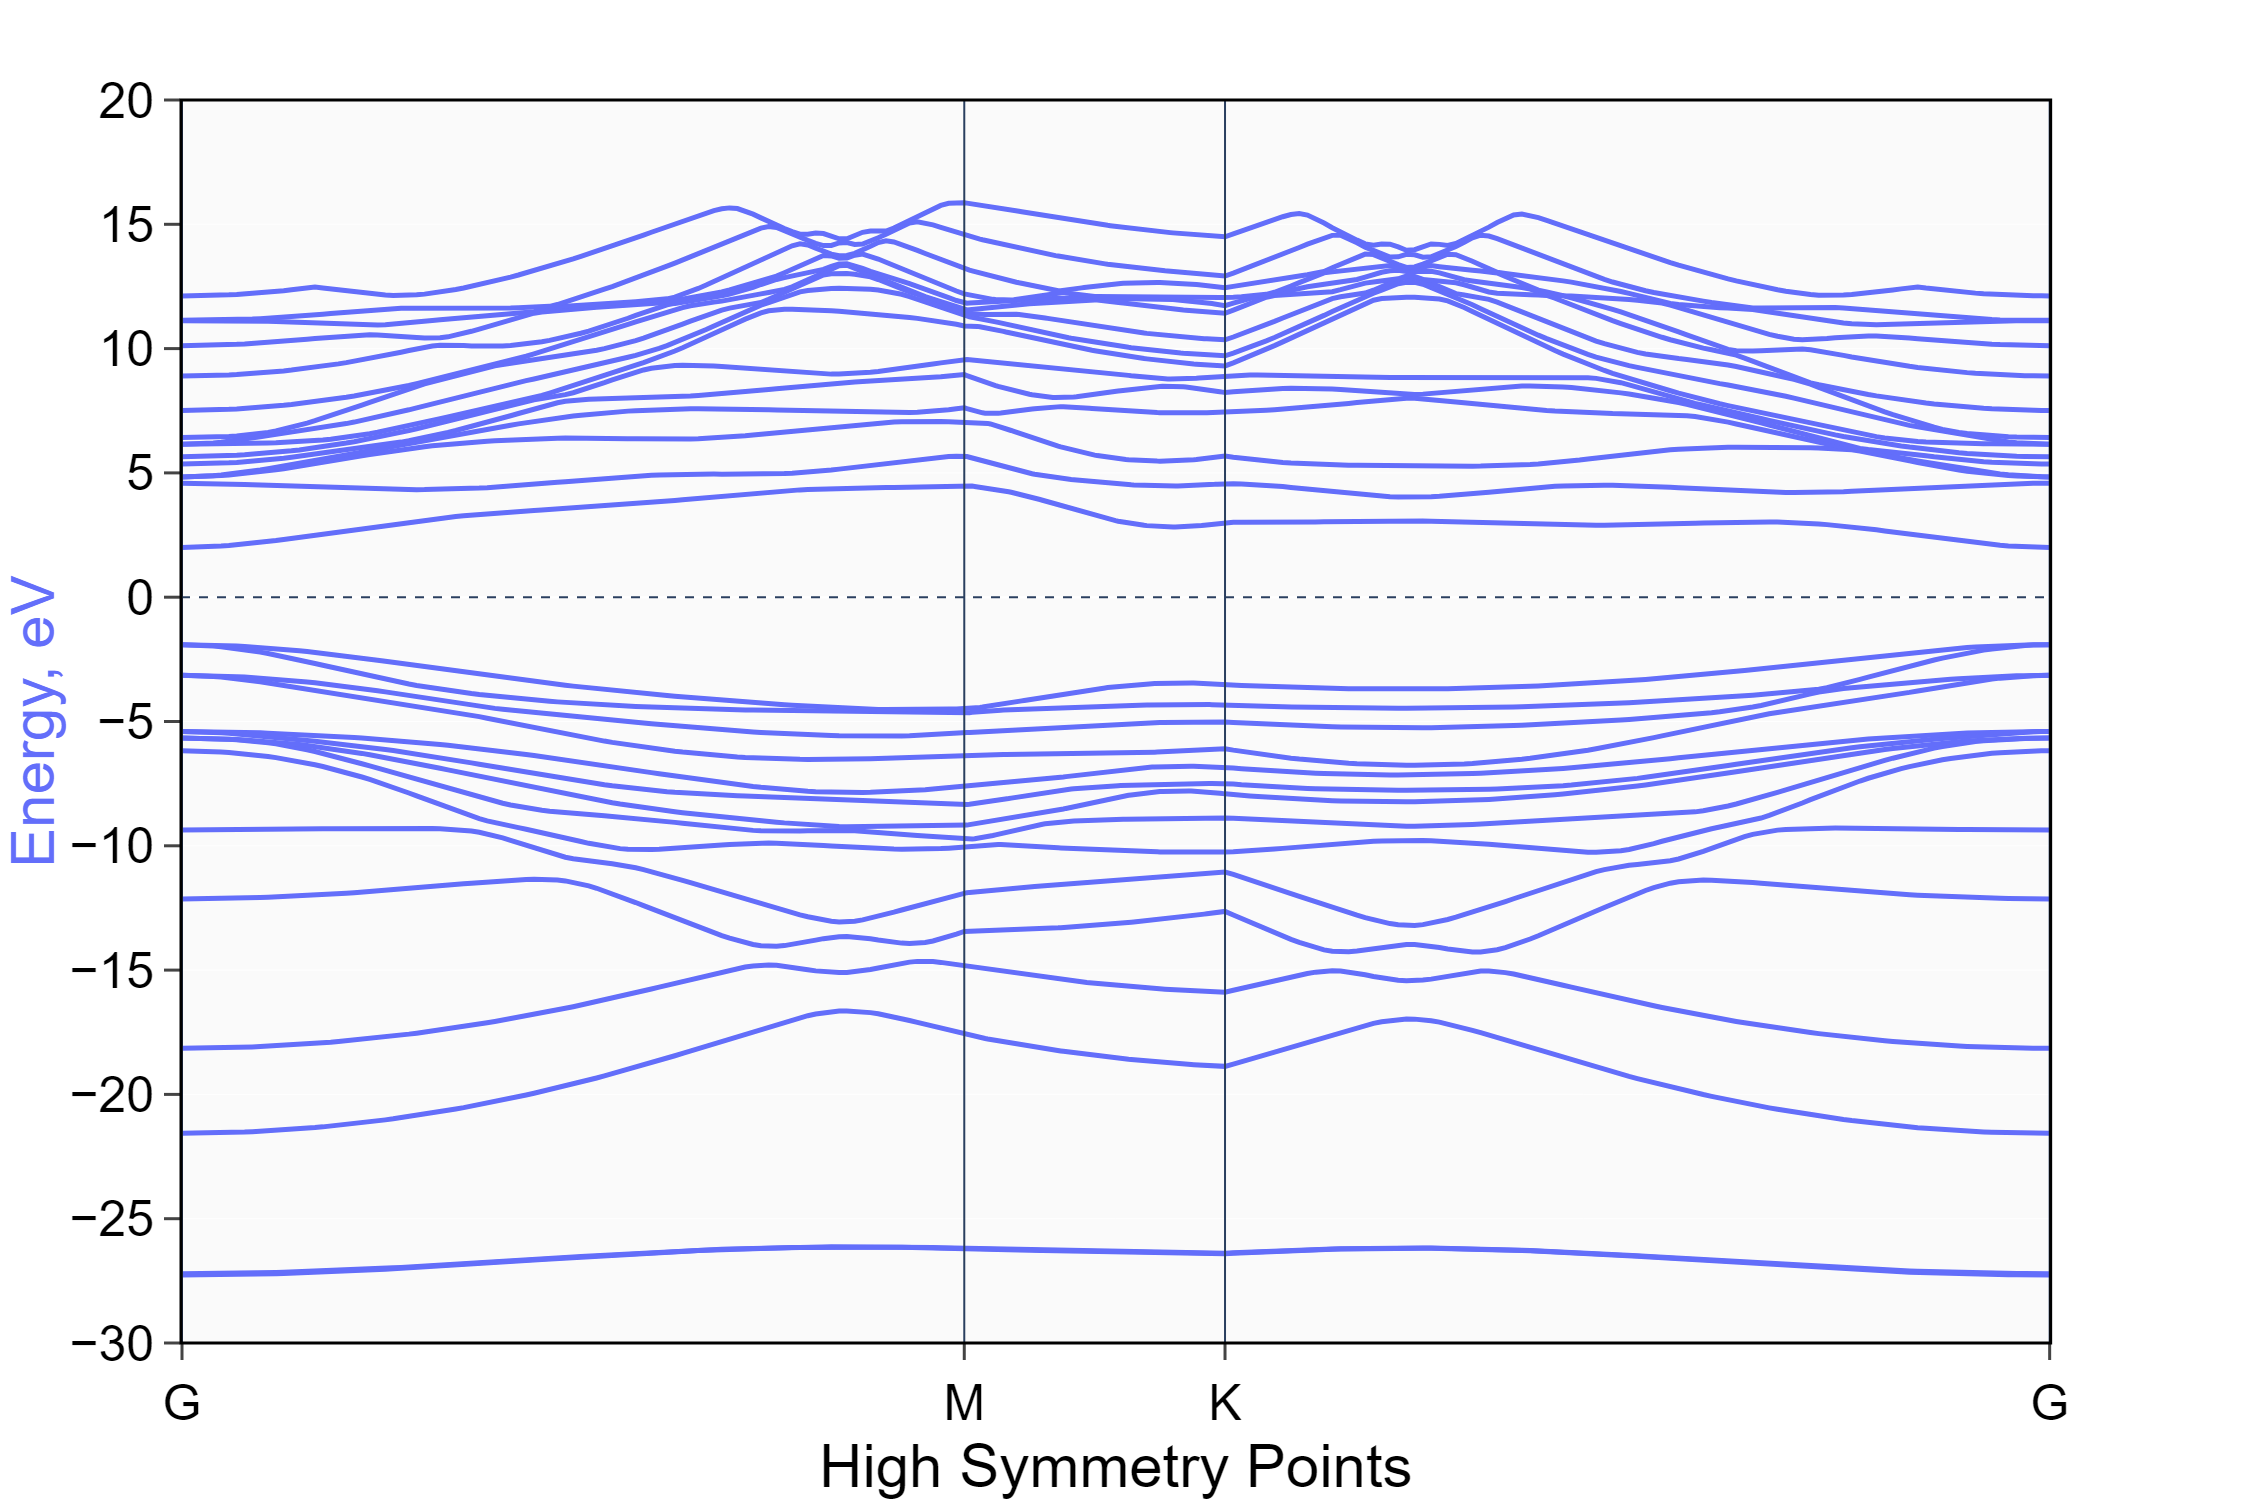

In [135]:
IPImage(open(bands_path / 'BANDS.png','rb').read())

## Combine DOS & BANDS figures

### Create a working directory

In [141]:
comb_img_path = create_folder(main_dir=main_dir, folder='Images')

Folder Images is created


### Copy DOS | BANDS Figures

In [142]:
shutil.copy(src=dos_path / 'DOS_rotated.png', dst=comb_img_path / 'DOS_rotated.png')
shutil.copy(src=bands_path / 'BANDS.png', dst=comb_img_path / 'BANDS.png')

WindowsPath('C:/Users/79179/Desktop/шк/Skoltech_PhD/Computational_Methods_for_Atomistic_Simulations/Labs/Lab_test/Images/BANDS.png')

### Combine Images

In [143]:
# Download images
img1 = Image.open(comb_img_path / "BANDS.png")
img2 = Image.open(comb_img_path / "DOS_rotated.png")

# Make sure that images have the same height
img2 = img2.resize((img2.width, img1.height))

# Create empty new figure
new_width = img1.width + img2.width
new_height = max(img1.height, img2.height)

combined_image = Image.new("RGBA", (new_width, new_height))

# Insert Images
combined_image.paste(img1, (0, 0))
combined_image.paste(img2, (img1.width-180, 0))

# Сохраняем результат
combined_image.save(comb_img_path / "merged_DOS_BANDS.png")

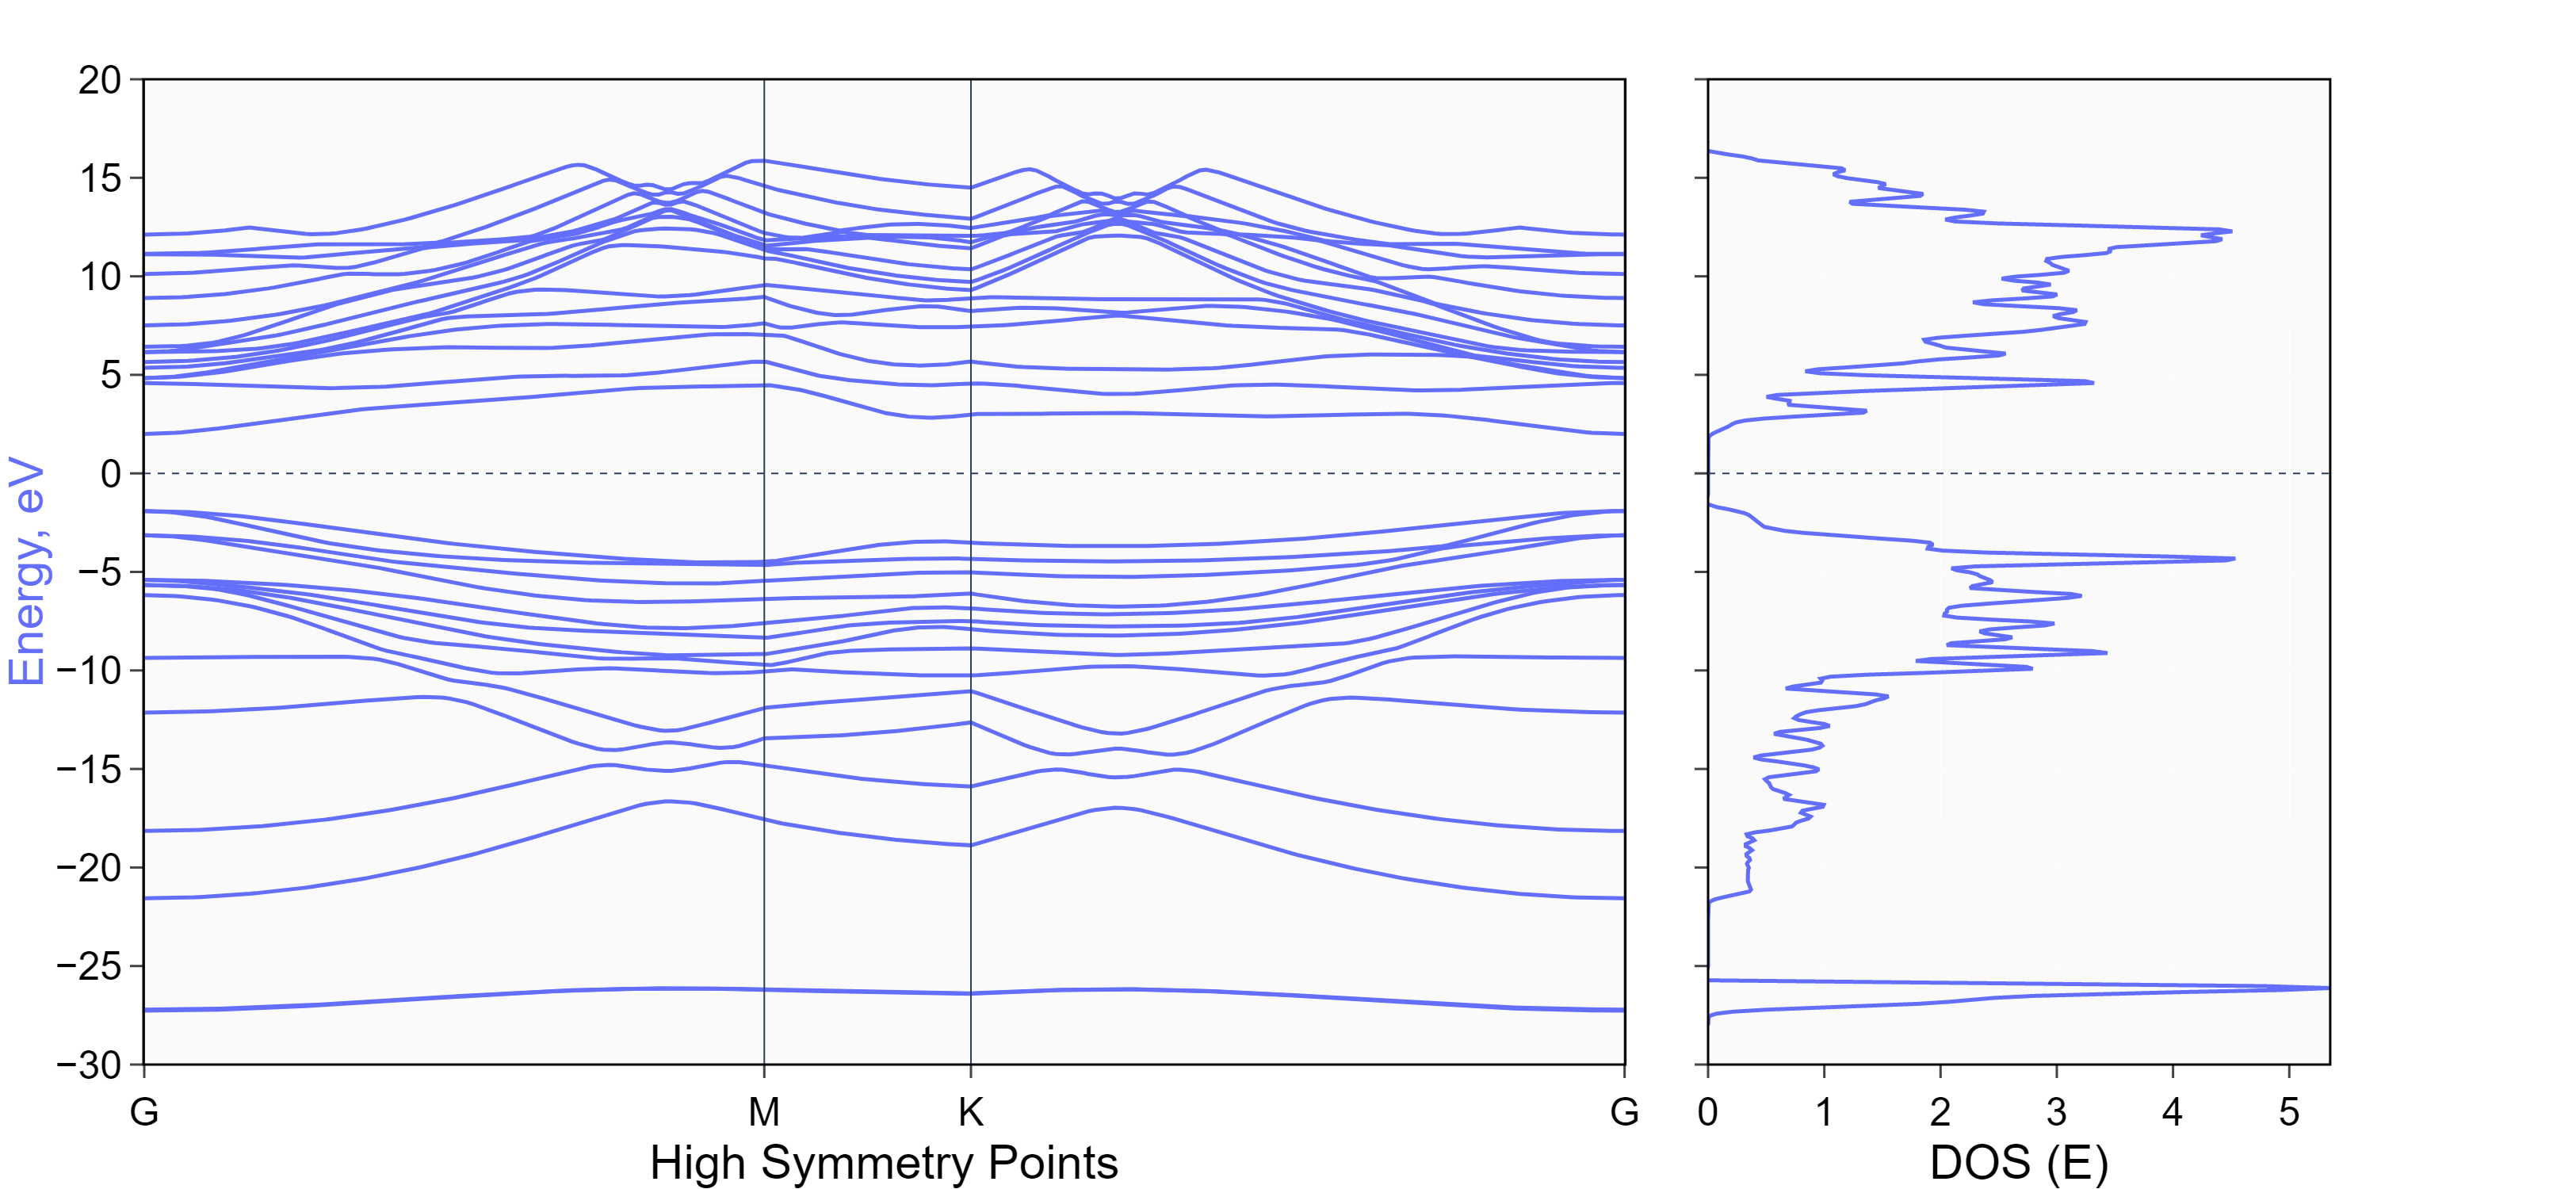

In [144]:
IPImage(open(comb_img_path / 'merged_DOS_BANDS.png','rb').read())

## Mechanical properties

### Create a working directory

In [4]:
mech_path = create_folder(main_dir=main_dir, folder='5.Props.Mechanical')

Folder 5.Props.Mechanical already exists


### SCF Input File

> **IMPORTANT** <br>
Add `tprnfor` `tstress` parameters into **SCF** input file

In [149]:
%%writefile {mech_path / 'ab_f_scf.in'}
&CONTROL
  calculation = 'scf'
  etot_conv_thr =   1.0d-05
  forc_conv_thr =   1.0d-04
  outdir = '.'
  pseudo_dir = '.'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   2.0000000000d-02
  ecutrho =   3.6000000000d+02
  ecutwfc = 45
  ibrav = 0
  nat = 6
  nosym = .false.
  ntyp = 2
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  mixing_beta = 0.4
  conv_thr = 1.0d-08
/
&IONS
ion_dynamics = 'bfgs'
/
&CELL
cell_dofree = 'all'
cell_dynamics = 'bfgs'
press = 0.0
press_conv_thr = 0.5
/
ATOMIC_SPECIES
C      12.0107 C.pbesol-n-kjpaw_psl.1.0.0.UPF
F      18.9984032 F.pbesol-n-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
C            0.0000192372       0.0000205709       0.5034283996
C            0.3333423734       0.3333433869       0.5286075473
C            0.6666304467       0.6666281225       0.6315737963
C            0.3333076240       0.3333055973       0.6063941121
F            0.0000446463       0.0000447066       0.4344390035
F            0.6666023731       0.6666014193       0.7005636096

K_POINTS automatic
12 12 1 0 0 0

CELL_PARAMETERS angstrom
   2.546011282  -0.000000525   0.000000000
   1.273005480   2.204910623   0.000000000
   0.001630521   0.000956614  19.976486115

Writing C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational_Methods_for_Atomistic_Simulations\Labs\Lab_test\5.Props.Mechanical\ab_f_scf.in


### Create input files with different celldm_1

> **IMPORTANT** <br>

You can obtain `celldm_1` value from CELL_PARAMETERS

In [32]:
celldm_1 = 2.546011282
cell_shifts = np.linspace(-0.05, 0.05, 11)
cell_vals = [f'   {(2.546011282+i):.9f}  -0.000000525   0.000000000\n' for i in cell_shifts]
create_rewrite_file(
    work_dir=mech_path,
    root_file='ab_f_scf.in', 
    new_file='ab_f', 
    parameter='CELL_PARAMETERS',
    steps=np.arange(len(cell_vals)),
    new_lines=cell_vals,
    app_path='C:/Users/79179/Desktop/qe/pw.exe',
    change_line='next'
)

> **RUN CALCULATIONS** <br>
pw.x < ab_f_scf.in > ab_f_scf.out

### Calculate Mechanical Properties

In [29]:
def find_mech_prop(work_dir: str, new_file: str, steps: list):
    unit_cell_vol = np.zeros(len(steps))
    lattice_param = np.zeros_like(unit_cell_vol)
    pressure = np.zeros_like(unit_cell_vol)
    c11_vals, c12_vals, c13_vals = np.zeros_like(unit_cell_vol), np.zeros_like(unit_cell_vol), np.zeros_like(unit_cell_vol)
    stresses = np.zeros((len(steps), 3, 3))

    f2, f3, f4, f5 = open(work_dir/'data.cell', 'w'), open(work_dir/'data.c11', 'w'), open(work_dir/'data.c12', 'w'), open(work_dir/'data.c13', 'w')
    for step in steps:
        with open(work_dir / f'{new_file}_{step}.out') as f1:
            flag = False
            count = 0            
            for line in f1:
                if 'lattice parameter' in line:
                    lattice_param[step] = float(list(filter(None, line.split(' ')))[-2])
                    f2.write(f'{lattice_param[-1]}\n')
                if 'unit-cell volume' in line:
                    unit_cell_vol[step] = float(list(filter(None, line.split(' ')))[-2])
                elif flag:
                    if count == 0:
                        # Stress: σ_xx, σ_xy, σ_xz
                        stresses[step, 0, :] = list( map(float, list(filter(None, line.split(' ')))[:3]) )
                        # C11 value
                        c11_vals[step] = float(list(filter(None, line.split(' ')))[count-3])
                        f3.write(f'{c11_vals[-1]}\n')
                    elif count == 1:
                        # Stress: σ_yx, σ_yy, σ_yz
                        stresses[step, 1, :] = list( map(float, list(filter(None, line.split(' ')))[:3]) )
                        # C12 value
                        c12_vals[step] = float(list(filter(None, line.split(' ')))[count-3])
                        f4.write(f'{c12_vals[-1]}\n')
                    elif count == 2:
                        # Stress: σ_zx, σ_zy, σ_zz
                        stresses[step, 2, :] = list( map(float, list(filter(None, line.split(' ')))[:3]) )
                        # C13 value
                        c13_vals[step] = float(list(filter(None, line.split(' ')))[count-3])
                        f5.write(f'{c13_vals[-1]}\n')
                    count += 1
                    if count >= 3:
                        flag = False                   
                elif 'total' in line and 'stress' in line:
                    flag = True
                    pressure[step] = float(list(filter(None, line.split(' ')))[-1])
    f2.close(), f3.close(), f4.close(), f5.close()
    return stresses, unit_cell_vol, lattice_param, pressure, c11_vals, c12_vals, c13_vals

def bulk_modulus(press: np.array, vol: np.array, origin_vol: float):
    return - origin_vol * np.gradient(press, vol)

In [ ]:
stresses, unit_cell_vol, lattice_param, pressure, c11_vals, c12_vals, c13_vals = find_mech_prop(
    work_dir=mech_path,
    new_file='ab_f',
    steps=np.arange(len(cell_vals))
)
mech_total_energy = find_total_energy(
    work_dir=mech_path,
    new_file='ab_f',
    steps=np.arange(len(cell_vals)),
)

#### Strain Calculations
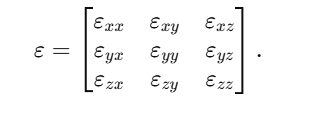

> **IMPORTANT** <br>
- Only xx_strains `celldm_1` were applied in the X-direction in this calculations. That is why yy_strains and zz_strains equal to zero.
- Also xy_strains, xz_strains and other derivatives in Y- and Z-directions equal to zero.
- If you would like to calculate them you need to implement calculations with other cell shifts and reconstruct `find_mech_prop` function

In [42]:
# Strains ε_xx, ε_xy, ε_xz
strain_xx = [((celldm_1+i) - celldm_1)/celldm_1 for i in cell_shifts]
strain_xy = np.zeros(len(cell_shifts))
strain_xz = np.zeros(len(cell_shifts))

# Strain ε_yx, ε_yy, ε_yz
strain_yx = np.zeros(len(cell_shifts))
strain_yy = np.zeros(len(cell_shifts))
strain_yz = np.zeros(len(cell_shifts))

# Strain ε_zx, ε_zy, ε_zz
strain_zx = np.zeros(len(cell_shifts))
strain_zy = np.zeros(len(cell_shifts))
strain_zz = np.zeros(len(cell_shifts))

strain_matrix = np.zeros((len(cell_shifts), 3, 3))
for i in range(len(cell_shifts)):
    for j in range(3):
        strain_matrix[i, 0, :] = [strain_xx[i], strain_xy[i], strain_xz[i]]
        strain_matrix[i, 1, :] = [strain_yx[i], strain_yy[i], strain_yz[i]]
        strain_matrix[i, 2, :] = [strain_zx[i], strain_zy[i], strain_zz[i]]

In [46]:
stresses[0]

array([[ 3.5687e-04, -9.0990e-05, -5.4100e-06],
       [-9.0990e-05,  4.0060e-05,  6.8400e-06],
       [-5.4100e-06,  6.8400e-06, -1.5845e-04]])

In [44]:
Cij = np.linalg.solve(strain_matrix[0], stresses[0])

LinAlgError: Singular matrix

In [41]:
c11_vals

array([ 52.5 ,  41.37,  30.55,  20.04,   9.84,  -0.09,  -9.73, -19.1 ,
       -28.2 , -37.02, -45.6 ])

In [36]:
Cij

array([[-0.0181719 ,  0.00463323,  0.00027548],
       [ 0.00463323, -0.00203986, -0.00034829],
       [ 0.00027548, -0.00034829,  0.00806831]])

#### Bulk Modulus

In [174]:
with open(mech_path / 'ab_f_scf.out', 'r+') as f:
    for line in f:
        if 'unit-cell volume' in line:
            origin_vol = float(list(filter(None, line.split(' ')))[-2])
            break

bulk_moduli = bulk_modulus(
    press=pressure,
    vol=unit_cell_vol,
    origin_vol=origin_vol
)

### Make Figures

#### Unit cell volume | Total energy

In [179]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=unit_cell_vol,
            y=mech_total_energy,
            line_color=color_dict[0],
            line_width=5,
            showlegend=False,
            name=''
            ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                font_color='black',
                title = "Total energy vs Volume",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 2250,
                height = 1500,   
                # X-axis
                xaxis_title = "Volume, a.u.",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                # Y-axis-right
                yaxis_title = "Total Energy, Ry",
                #yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside',
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))

fig.layout.font.family = 'sans-serif'
fig.write_image(file=mech_path / "Volume_Energy.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
#fig.show()

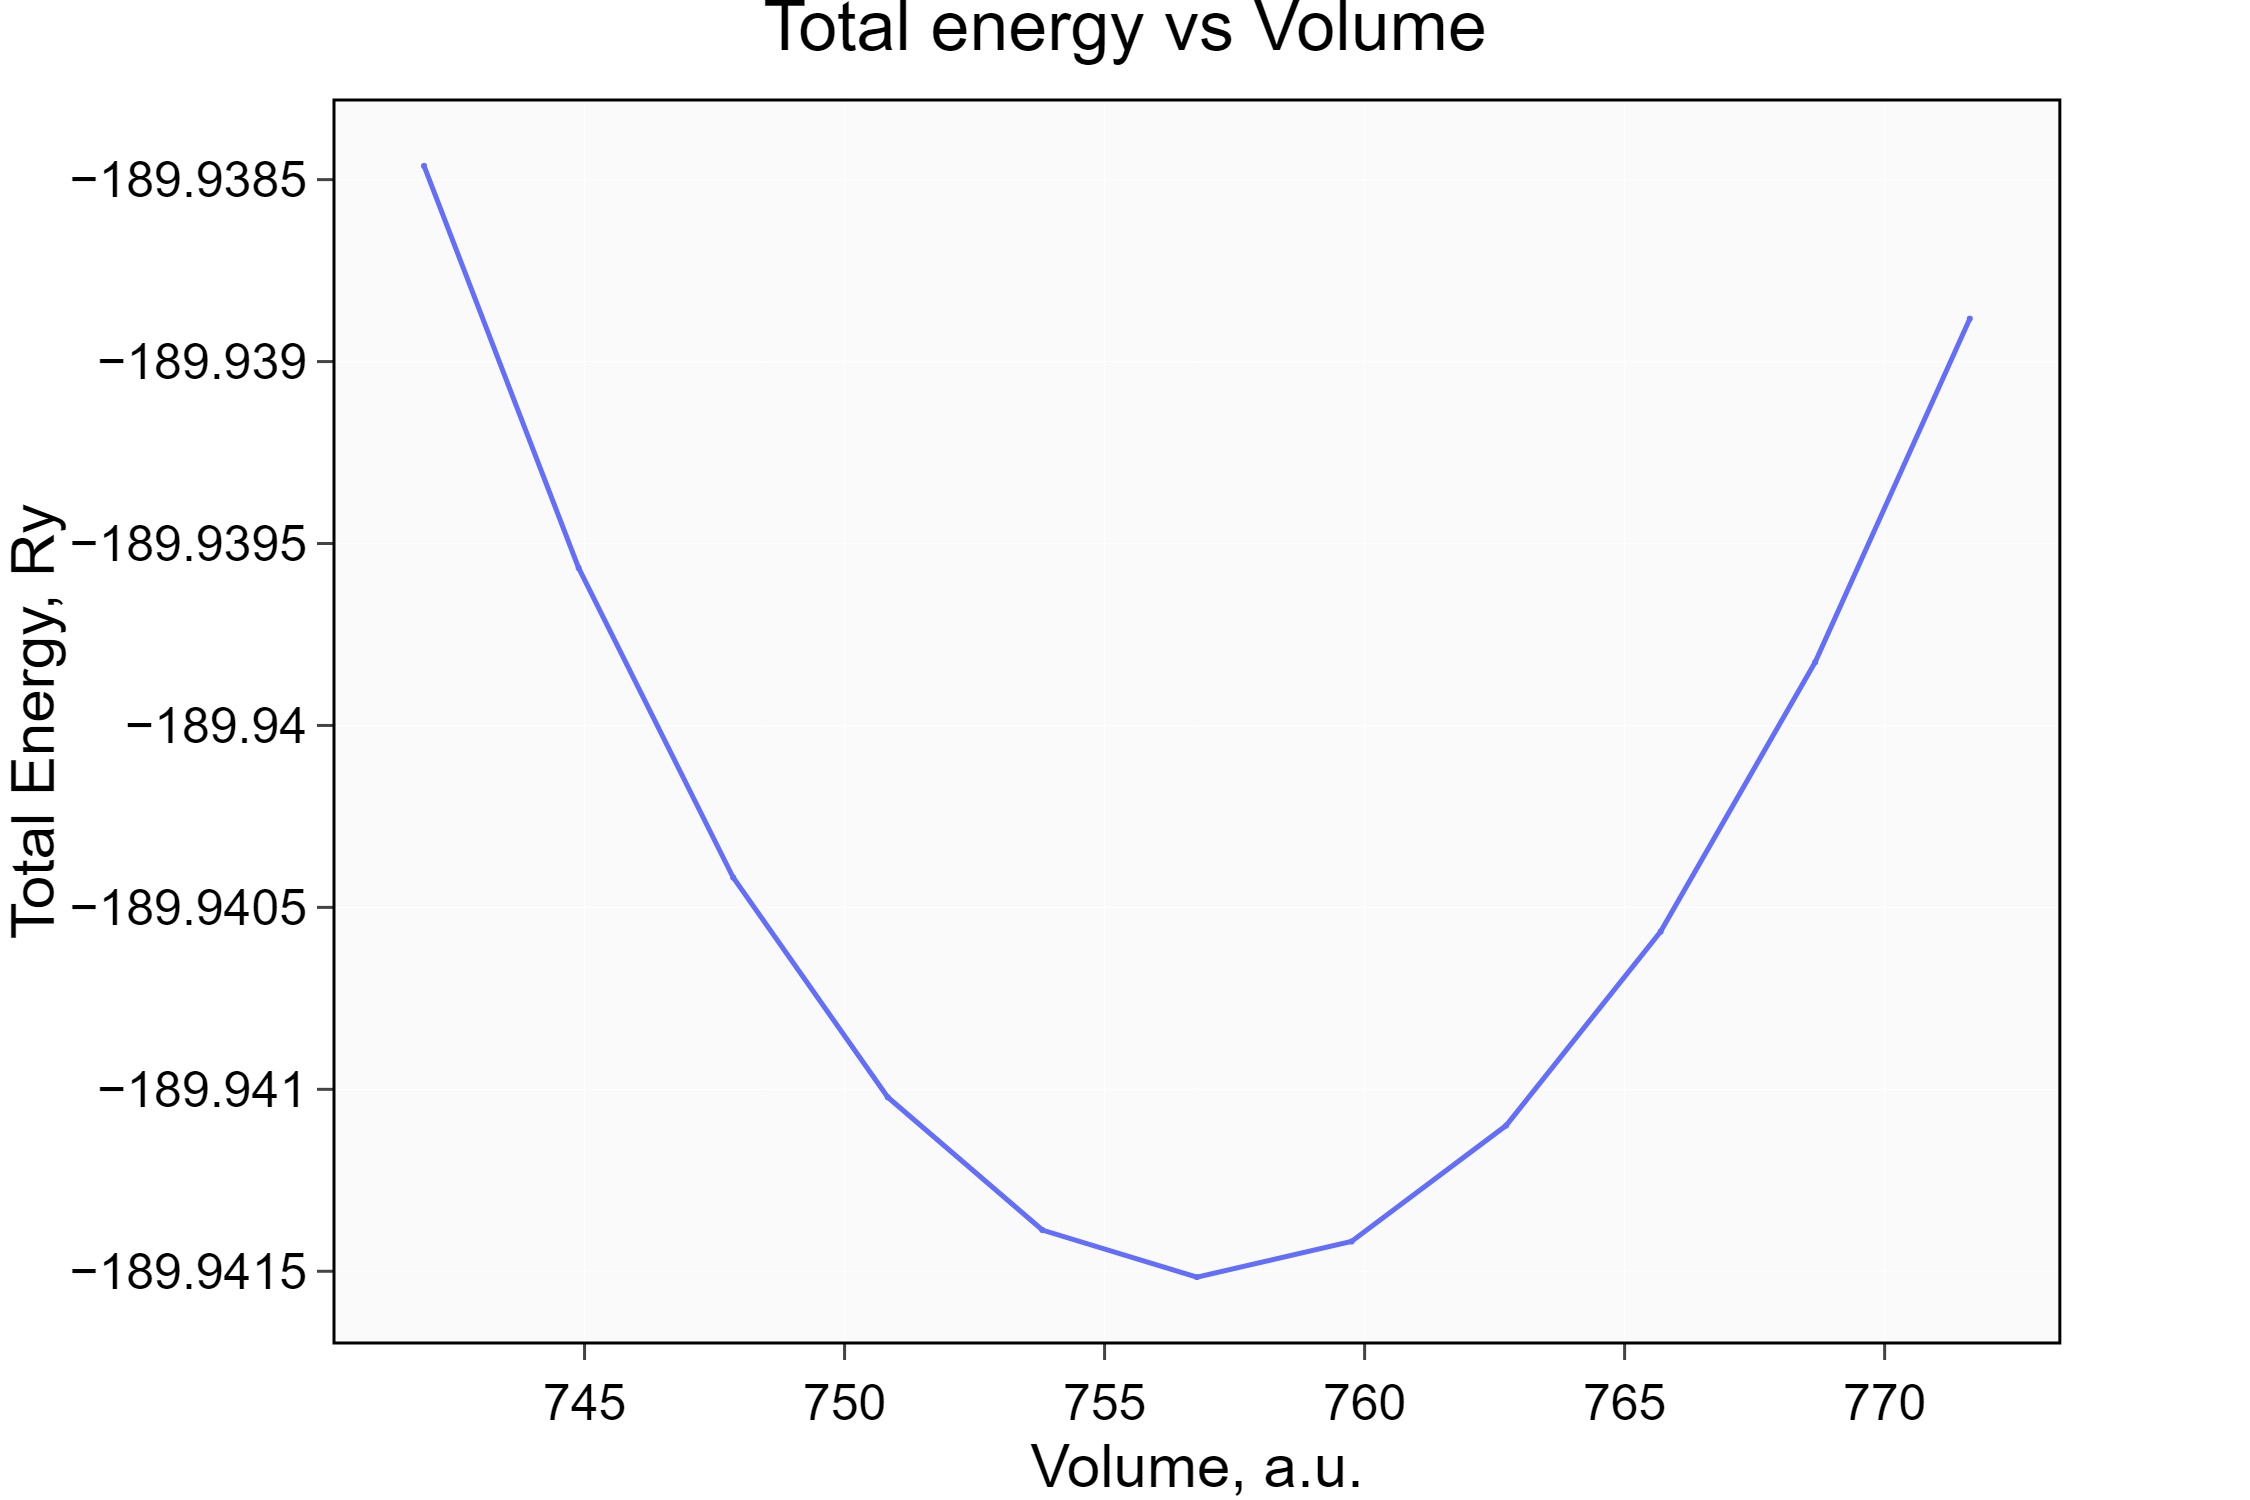

In [180]:
IPImage(open(mech_path / 'Volume_Energy.png','rb').read())

#### Bulk Moduli | Pressure

In [181]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

color_dict = px.colors.qualitative.Plotly

# Add traces
fig.add_trace(
    go.Scatter(x=pressure,
            y=bulk_moduli,
            line_color=color_dict[0],
            line_width=5,
            showlegend=False,
            name=''
            ),
    secondary_y=False,)

# Add figure title
fig.update_layout(font_size = 50,
                font_color='black',
                title = "Bulk moduli vs Pressure",
                title_x = 0.5,
                #legend_title = "Measurement<br>parameters",
                legend_font_size = 50,
                plot_bgcolor = 'rgba(250,250,250,1)',
                width = 2250,
                height = 1500,   
                # X-axis
                xaxis_title = "Pressure, kBar",
                xaxis_nticks = 7,
                xaxis_ticklen = 16,
                xaxis_tickwidth = 3,
                xaxis_ticks = 'outside',
                # Y-axis-right
                yaxis_title = "Bulk moduli",
                #yaxis_titlefont_color=color_dict[0],
                yaxis_nticks = 12,
                yaxis_ticklen = 16,
                yaxis_tickwidth = 3,                                           
                yaxis_ticks = 'outside',
                # Y-axis-left
                yaxis2_title = "Refractive Index",
                yaxis2_titlefont_color=color_dict[2],
                yaxis2_nticks = 12,
                yaxis2_ticklen = 16,
                yaxis2_tickwidth = 3,                                           
                yaxis2_ticks = 'outside',
                )   

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=0.94,
                y1=1.0,
        line=dict(
            color="black",
                width=3,))

fig.layout.font.family = 'sans-serif'
fig.write_image(file=mech_path / "BulkMod_Pressure.png",
                format='png',
                width=2250,
                height=1500,
                scale=1
                )
#fig.show()

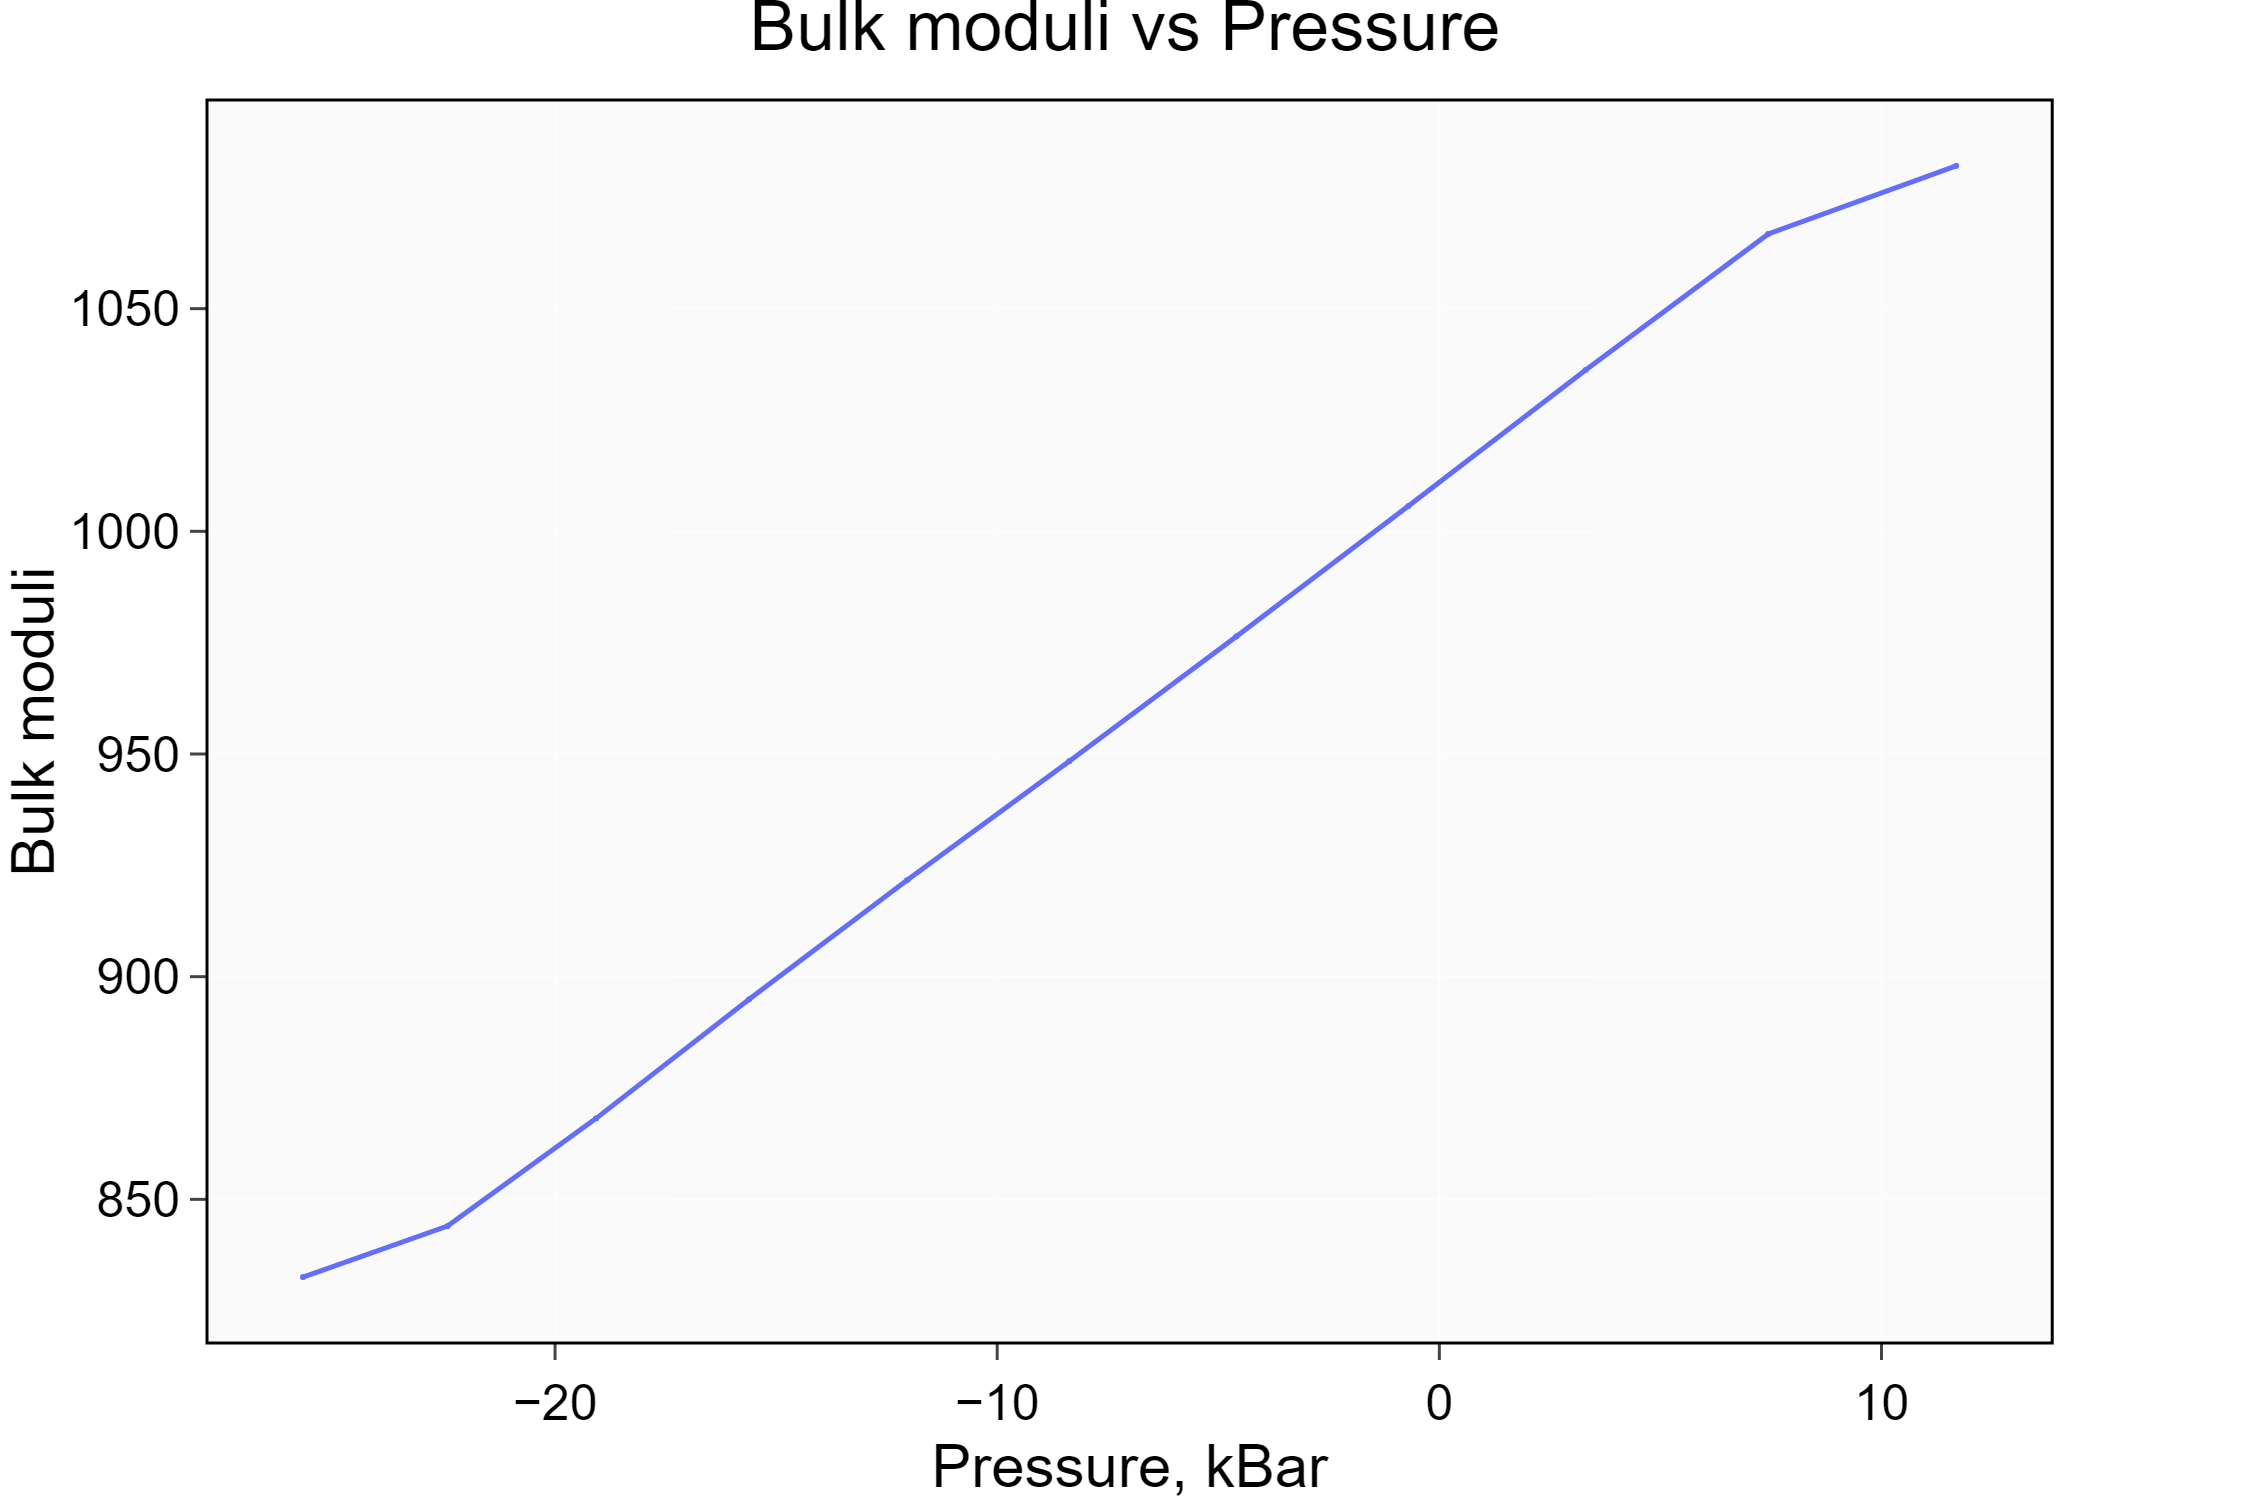

In [182]:
IPImage(open(mech_path / 'BulkMod_Pressure.png','rb').read())

## Phonon Dispersion

### Create a working directory

In [ ]:
phdos_path = create_folder(main_dir=main_dir, folder='6.phDOS')

In [51]:
curr_dir = 'C:\\Users\\79179\\Desktop\\шк\\Skoltech_PhD\\Computational Methods for Atomistic Simulations\\Labs\\Lab1'
os.chdir(curr_dir)
if os.path.exists(curr_dir):
    print('Current Directory:')
    print(curr_dir)
else:
    print('Directory does not exists')

folder = "1_5_PhDOS"
if not os.path.exists(f'{curr_dir}/{folder}'):
    os.mkdir(f'{curr_dir}/{folder}')
print()
print(f'File {folder} is created')
print()

os.chdir(f'{curr_dir}/{folder}')
print('Move to Directory:')
print(os.getcwd())


Current Directory:
C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational Methods for Atomistic Simulations\Labs\Lab1

File 1_5_PhDOS is created

Move to Directory:
C:\Users\79179\Desktop\шк\Skoltech_PhD\Computational Methods for Atomistic Simulations\Labs\Lab1\1_5_PhDOS


### Files Preparation

> **IMPORTANT**

> Make sure you have **SCF** input file

In [55]:
def create_phdos_files(app_path: str, file_type: str, scf_thrs: str, verbosity: str, amass: list, nq: list, zasr: str, nk: list, epsil: str, raman_spec: str, IR_spec: str, alphamat: str, hsp_kpoints: list):
    with open(f"{file_type}_ph.in", 'w') as f:
        f.write("Phonon Calculation\n")
        f.write("&INPUTPH\n")
        f.write(f"  outdir = '.'\n")
        f.write(f"  prefix = '{file_type}'\n")
        f.write(f"  tr2_ph = {scf_thrs}\n")
        f.write(f"  ldisp = .true.\n")
        f.write(f"  verbosity = '{verbosity}'\n")

        for i, mass in enumerate(amass):
               f.write(f"  amass({i+1}) = {mass}\n")

        f.write(f"  nq1 = {nq[0]}, nq2 = {nq[1]}, nq3 = {nq[2]}\n")
        f.write(f'  epsil = {epsil}\n')
        f.write(f'  trans = {raman_spec}\n')
        f.write(f'  elop = {IR_spec}\n')
        f.write(f'  alphamat = {alphamat}\n')
        f.write(f'  reduce_io = .true.\n')
        f.write(f"  fildyn = '{file_type}.dyn'\n/\n")
        f.close()
    
    with open(f"{file_type}_q2r.in", 'w') as f:
        f.write("&INPUT\n")
        f.write(f"  fildyn = '{file_type}.dyn'\n")
        f.write(f"  zasr = '{zasr}'\n")
        f.write(f"  flfrc = {file_type}_k{nq[0]}.fc\n/\n")
        f.close()
    
    with open(f"{file_type}_matdyn_DOS.in", 'w') as f:
        f.write("&INPUT\n")
        f.write(f"  asr = '{zasr}'\n")
        f.write(f"  flfrc = {file_type}_k{nq[0]}.fc\n")
        f.write(f"  flfrq = {file_type}.phdos.freq\n")
        f.write(f"  flvec = {file_type}.phdos.modes\n")
        f.write(f"  dos = .true.\n")
        f.write(f"  fldos = {file_type}.phdos\n")
        f.write(f"  nk1 = {nk[0]}, nk2 = {nk[1]}, nk3 = {nk[2]}\n/\n")
        f.close()
    
    with open(f"{file_type}_matdyn_dispersion.in", 'w') as f:
        f.write("&INPUT\n")
        f.write(f"  asr = '{zasr}'\n")

        for i, mass in enumerate(amass):
               f.write(f"  amass({i+1}) = {mass}\n")

        f.write(f"  flfrc = {file_type}_k{nq[0]}.fc\n")
        f.write(f"  flfrq = {file_type}.freq\n")
        f.write(f"  flvec = {file_type}.modes\n")
        f.write(f"  q_in_band_form = .true.\n")
        f.write(f"  q_in_cryst_coord = .true.\n/\n")
        f.write(f"{len(hsp_kpoints)}\n")

        for kpts in hsp_kpoints:
            f.write(f"{kpts[0]} {kpts[1]} {kpts[2]} {kpts[3]} \n")
        f.close()


    with open('autorun.bat', 'w') as f:
        f.write(f'{app_path}pw.exe < {file_type}_scf.in > {file_type}_scf.out\n')
        f.write(f'{app_path}ph.exe < {file_type}_ph.in > {file_type}_ph.out\n')
        f.write(f'{app_path}q2r.exe < {file_type}_q2r.in > {file_type}_q2r.out\n')
        f.write(f'{app_path}matdyn.exe < {file_type}_matdyn_DOS.in > {file_type}_matdyn_DOS.out\n')
        f.write(f'{app_path}matdyn.exe < {file_type}_matdyn_dispersion.in > {file_type}_matdyn_dispersion.out\n')
        f.close()


In [ ]:
create_phdos_files(
    app_path='C:/Users/79179/Desktop/qe/',
    file_type='ab_f',
    scf_thrs='1.0d-8',
    verbosity='high',
    amass = [12.0107, 18.9984],
    nq = [12, 12, 1],
    zasr = 'crystal',
    nk = [100, 100, 100],
    epsil = '.true.',
    raman_spec = '.true.',
    IR_spec = '.true.',
    alphamat = '.true.',
    hsp_kpoints = [
        [0.0000000000, 0.0000000000, 0.0000000000, 100],
        [0.5000000000, 0.5000000000, 0.0000000000, 100],
        [0.6666666666, 0.3333333333, 0.0000000000, 100],
        [0.0000000000, 0.0000000000, 0.0000000000, 100],
    ]
)